In [1]:
#https://github.com/vinayprabhu/sub-sequence-search
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import distance
from scipy.stats import zscore
from numpy.fft import fft, ifft

#TSC1_demo( VarName3(1:end-30) ,50);
원본코드 사용예에 나와있듯이 multivariate dataset에서 한칼럼씩 추출하는 함수임

In [2]:
def fastfindNNPre(x, m):
    n = len(x)  # m = len(y)  

    # matlab : x(n+1:2*n) = 0; => n+1 ~ 2n 길이의 0행렬을 x에 더함
    x = np.concatenate((x, np.zeros((2*n - n))))
    
    X = fft(x)
    cum_sumx=np.cumsum(x)
    cum_sumx2=np.cumsum(x ** 2)
    sumx2=cum_sumx2[m:n] - cum_sumx2[0:n-m]
    sumx=cum_sumx[m:n] - cum_sumx[0:n-m]
    meanx=sumx / m
    sigmax2=(sumx2 / m) - (meanx ** 2)
    sigmax=np.sqrt(sigmax2) 
    
    return X, n, sumx2, sumx, meanx, sigmax2, sigmax

def fastfindNN(X, y, n, m, sumx2, sumx, meanx, sigmax2, sigmax):
    dropval = y[0]
    y = y[::-1];#Reverse the query
    
    # matlab : y(m+1:2*n) = 0; => m+1 ~ 2n 길이의 0행렬을 y에 더함, x의 길이와 같아짐 
    y = np.concatenate((y, np.zeros((2*n - m))))

    #The main trick of getting dot products in O(n log n) time
    Y = fft(y)
    Z = X*Y
    z = ifft(Z)
    
    #compute y stats -- O(n)
    sumy = sum(y)
    sumy2 = sum(y ** 2)
    meany=sumy/m
    sigmay2 = (sumy2/m)-(meany **2)
    sigmay = np.sqrt(sigmay2)                          

    dist = 2*(m-(z[m:n]-m*meanx*meany)/(sigmax*sigmay))
    dist = np.sqrt(dist)
    lastz = np.real(z[m:n])
    
    return dist, lastz, dropval, sumy, sumy2

In [3]:
def TSC1_chainlength(A, SubsequenceLength):
    #set trivial match exclusion zone
    exclusionZone = round(SubsequenceLength/4);
    
    #check input
    if SubsequenceLength > len(A)/2:
        error('Error: Time series is too short relative to desired subsequence length')
    elif SubsequenceLength < 4 :
        error('Error: Subsequence length must be at least 4');
    #elif len(A) == A.shape[1] :
    #    A = A.T 
    
    #initialization
    MatrixProfileLength = len(A) - SubsequenceLength
    MPLeft=np.tile(np.inf,(MatrixProfileLength,1)) #numpy tile : repeat matrix
    MPindexLeft=np.zeros((MatrixProfileLength,1))
    MPRight=np.tile(np.inf,(MatrixProfileLength,1))
    MPindexRight=np.zeros((MatrixProfileLength, 1))
    X,n,sumx2,sumx,meanx,sigmax2,sigmax=fastfindNNPre(A,SubsequenceLength)

    #compute the matrix profile
    pickedIdx = np.arange(MatrixProfileLength)
    dropval=0
    distanceProfile=np.zeros((MatrixProfileLength,1))
    lastz=np.zeros((MatrixProfileLength,1))
    updatePosLeft=np.full((MatrixProfileLength,1),False)
    updatePosRight=np.full((MatrixProfileLength,1),False)

    for i in range(MatrixProfileLength):
        idx=pickedIdx[i]
        subsequence=A[idx:idx + SubsequenceLength]
        distanceProfile[:,0],lastz,dropval,lastsumy,lastsumy2=fastfindNN(X,subsequence,n,SubsequenceLength,sumx2,sumx,meanx,sigmax2,sigmax)

        if i == 0:
            distanceProfile[:,0]=abs(distanceProfile[:,0])
            firstz=lastz

        else:
            lastsumy=lastsumy - dropval + subsequence[-1]
            lastsumy2=lastsumy2 - dropval ** 2 + subsequence[-1] ** 2

            meany=lastsumy / SubsequenceLength
            sigmay2=lastsumy2 / SubsequenceLength - meany ** 2
            sigmay=np.sqrt(sigmay2)
            lastz[1:n - SubsequenceLength+2]=lastz[0:n - SubsequenceLength-1]- (A[0:n - SubsequenceLength-1] * dropval)\
                    + A[SubsequenceLength:n-1]* subsequence[-1]
            lastz[0]=firstz[i]
            distanceProfile[:,0]=np.sqrt(2*(SubsequenceLength - (lastz - (SubsequenceLength*meanx*meany)) / (sigmax*sigmay)))
            dropval=subsequence[1]

        exclusionZoneStart = max(1, idx-exclusionZone)
        exclusionZoneEnd = min(MatrixProfileLength, idx+exclusionZone)
        distanceProfile[exclusionZoneStart:exclusionZoneEnd] = np.inf

        # figure out and store the neareest neighbor
        updatePosLeft[1:(idx-1)] = False
        updatePosLeft[idx:MatrixProfileLength] = distanceProfile[idx:MatrixProfileLength] < MPLeft[idx:MatrixProfileLength]
        MPLeft[updatePosLeft] = distanceProfile[updatePosLeft]
        MPindexLeft[updatePosLeft] = idx

        updatePosRight[(idx+1):MatrixProfileLength] = False
        updatePosRight[1:idx] = distanceProfile[1:idx] < MPRight[1:idx]
        MPRight[updatePosRight] = distanceProfile[updatePosRight]
        MPindexRight[updatePosRight]= idx
        
    ChainPos = np.full((MatrixProfileLength,1),False)
    ChainLength = np.zeros((MatrixProfileLength,1))

    for i in range(MatrixProfileLength):
        if (~ChainPos[i]):
            cur=i
            count=1
            #while int(MPindexRight[cur])>0 and int(MPindexLeft[int(MPindexRight[cur])])==cur:
            while MPindexRight[int(cur)]>0 and MPindexLeft[int(MPindexRight[int(cur)])]==cur:
                ChainPos[int(cur)]=True
                cur=MPindexRight[int(cur)]
                count=count+1
            ChainLength[i]=count
    
    #Note that ChainLength and ChainPos show all possible chains within the time series. 
    #The following code only outputs the longest chain possible, 
    #but actually with these two vectors, we can show any chain within the time series. 
    
    #anchor가 없는 경우만으로 단순화
    ChainStart = np.argmax(ChainLength)
    count=int(ChainLength[ChainStart])
    
    curmax=0
    curmin=0
    curmaxdiff=0
    curmindiff=0

    cur=ChainStart
    next_num=ChainStart
    lastpattern=[]

    for i in range(count):
        next_num=MPindexRight[int(cur)]
        curpattern=zscore(A[int(cur):int(cur+SubsequenceLength)])
        if max(curpattern)>curmax :
            curmax=max(curpattern)
        if min(curpattern)<curmin :
            curmin=min(curpattern) 
        if i>=2 :
            diff=curpattern-lastpattern
            val1=max(diff)
            val2=min(diff)
            if val1>curmaxdiff :
                curmaxdiff=val1
            if val2<curmindiff :
                curmindiff=val2
        lastpattern=curpattern
        cur=next_num
    
    #one showing the chain within the time series
    i =1
    cur=int(ChainStart)
    lastpattern=[]
    
    plt.figure()
    plt.plot(A)
    while i<=count:  
        plt.plot(np.arange(int(cur),int(cur+SubsequenceLength)),A[int(cur):int(cur+SubsequenceLength)],'r')
        cur=MPindexRight[int(cur)]
        lastpattern=curpattern
        i=i+1
    plt.title("the chain within the time series")
    
    # the other enumerating all the subsequence in the chain, 
    # and at the same time showing the difference between every two subsequences in the chain.
    plt.figure()
    i =1
    cur=int(ChainStart)
    lastpattern=[]

    while i<=count:
        plt.subplot(np.ceil(count/count),count,i)
        curpattern=zscore(A[int(cur):int(cur+SubsequenceLength)])
        plt.plot(np.arange(int(cur),int(cur+SubsequenceLength)),curpattern)
        plt.xlim([cur,cur+SubsequenceLength])
        plt.ylim([curmin,curmax])
        if i>1 :
            plt.hold(True)
            plt.plot(np.arange(int(cur),int(cur+SubsequenceLength)),-lastpattern+curpattern,'r')
        cur=MPindexRight[int(cur)]
        lastpattern=curpattern
        i=i+1
        
    plt.show()
    
    ########## fro evalutate robust
    MaxChainLength=np.max(ChainLength)
    ChainStart = np.argmax(ChainLength)

    cur=ChainStart
    i=1
    count=MaxChainLength

    Ldiscovered=np.zeros((1, len(A)))

    while i<=count:
        Ldiscovered[0, cur:(cur+SubsequenceLength)]=1
        cur=int(MPindexRight[cur])
        i=i+1

    return MaxChainLength, Ldiscovered

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:142: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python3.5/dist-packages/matp

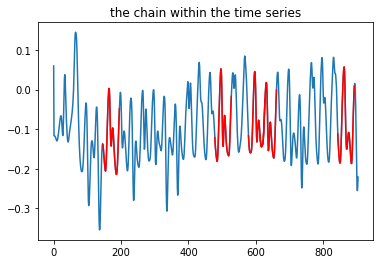

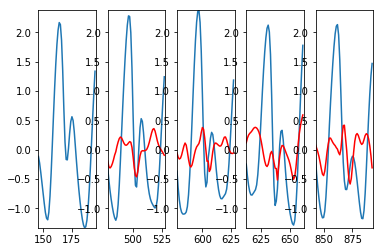

In [5]:
A = np.loadtxt("ID38_F_171354_[NexusOne]Rotation Matrix_12.txt", delimiter=',')
SubsequenceLength = 50

MaxChainLength, Ldiscovered=TSC1_chainlength(A[:,5], SubsequenceLength)